#Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

#Cargar la información

In [ ]:
df = pd.read_csv('Habitat-E.csv', index_col = 'Date', parse_dates = True)
df = df.asfreq('d') #Establece la frecuencia de la serie en diaria


##Verificar si existen valores nulos

In [ ]:
df.isnull().sum()     #Verifica si existen valores nulos

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

##Eliminar los datos que no se utilizarán en este análisis

In [ ]:
del df['Open']
del df['High']
del df['Low']
del df['Volume']

##Separar los datos en un conjunto de entrenamiento y prueba

In [ ]:
size = int(len(df)*0.8)
df_train, df_test = df[:size], df[size:]

##Comprobación de no coincidencia de fechas

In [ ]:
df_train.tail()

,Close
Date,
2019-11-21,41585
2019-11-22,41629
2019-11-23,41629
2019-11-24,41629
2019-11-25,41718


In [ ]:
df_test.head()

,Close
Date,
2019-11-26,41863
2019-11-27,41976
2019-11-28,41985
2019-11-29,41915
2019-11-30,41915


#Análisis exploratorio de los datos (tendencia, estacionalidad y residuos)

##Método aditivo

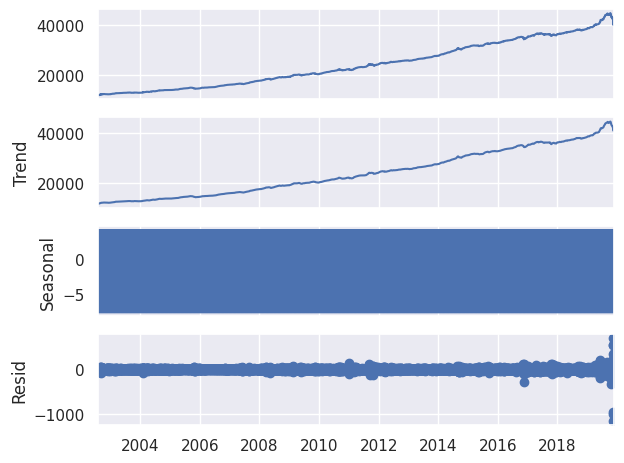

In [ ]:
s_dec_additive = seasonal_decompose(df_train, model = 'additive')
s_dec_additive.plot()
plt.show()

##Método multiplicativo

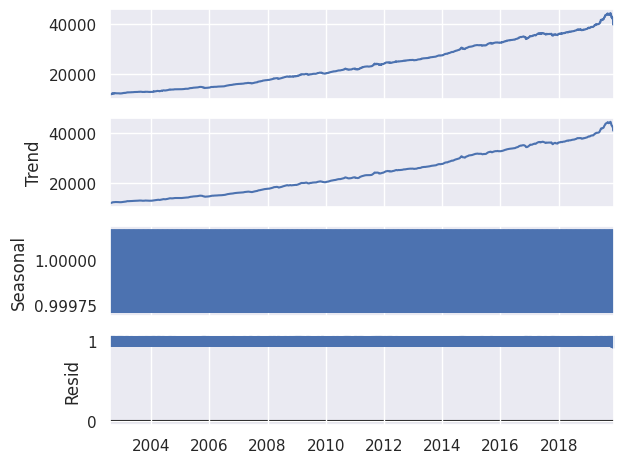

In [ ]:
s_dec_multiplicative = seasonal_decompose(df_train, model = 'multiplicative')    #En ambos casos no se evidencia una estacionalidad, pero si una tendencia positiva
s_dec_multiplicative.plot()
plt.show()

#Encontrar el mejor modelo que describa los datos

##Prueba de estacionariedad

In [ ]:
sts.adfuller(df_train.Close)     #Se obtuvo un valor P de 99% por lo que con una significancia de 5% existe evidencia de que no es una serie estacionaria

(1.4608997808718673,
 0.9973739770800493,
 32,
 6293,
 {'1%': -3.4313895629133992,
  '5%': -2.8619993951727514,
  '10%': -2.567014533031778},
 63407.25471217314)

##Función de log máxima verosimilitud

In [ ]:
def LLR_test(mod_1, mod_2, DF = 1):             #DF son los grados de libertad y se calculan con la diferencia en la cantidad de parametros que se necesita entre ambas predicciones
  L1 = mod_1.llf                                #llf es para calcular log verosimilitud de cada predicción
  L2 = mod_2.llf
  LR = (2*(L2 - L1))
  p = chi2.sf(LR,DF).round(3)
  return p

#Retornos

In [ ]:
df_train['returns'] = df_train.Close.pct_change(1).mul(100)

<ipython-input-12-70c3f036e9fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['returns'] = df_train.Close.pct_change(1).mul(100)


#Modelos autoregresivos

##Gráfico de autocorrelación

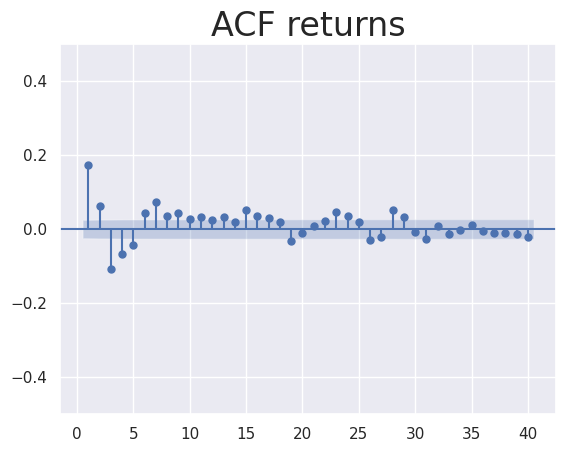

In [ ]:
sgt.plot_acf(df_train.returns[1:], lags = 40, zero = False)
plt.title('ACF returns', size = 24)                             #En el día 14 se encuentra el primer día no significativo
plt.ylim(-0.5, 0.5)
plt.show()

##Modelo autoregresivo de orden 1

In [ ]:
model_ar_1 = ARIMA(df_train.returns[1:], order= (1,0,0))
results_ar_1 = model_ar_1.fit()
print(results_ar_1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(1, 0, 0)   Log Likelihood                4000.832
Date:                Mon, 29 Apr 2024   AIC                          -7995.664
Time:                        03:36:44   BIC                          -7975.407
Sample:                    08-02-2002   HQIC                         -7988.648
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.009      0.000       0.016       0.024
ar.L1          0.1726      0.003     50.292      0.000       0.166       0.179
sigma2         0.0165   3.55e-05    465.027      0.0

##Modelo autoregresivo de orden 2

In [ ]:
model_ar_2 = ARIMA(df_train.returns[1:], order= (2,0,0))
results_ar_2 = model_ar_2.fit()
print(results_ar_2.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_1,results_ar_2 )))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(2, 0, 0)   Log Likelihood                4004.473
Date:                Mon, 29 Apr 2024   AIC                          -8000.947
Time:                        03:36:50   BIC                          -7973.938
Sample:                    08-02-2002   HQIC                         -7991.592
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.655      0.000       0.016       0.025
ar.L1          0.1667      0.005     30.358      0.000       0.156       0.177
ar.L2          0.0339      0.008      4.400      0.0

##Modelo autoregresivo de orden 3

In [ ]:
model_ar_3 = ARIMA(df_train.returns[1:], order= (3,0,0))
results_ar_3 = model_ar_3.fit()
print(results_ar_3.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_2,results_ar_3 )))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(3, 0, 0)   Log Likelihood                4057.316
Date:                Mon, 29 Apr 2024   AIC                          -8104.633
Time:                        03:36:56   BIC                          -8070.871
Sample:                    08-02-2002   HQIC                         -8092.940
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.802      0.000       0.016       0.024
ar.L1          0.1711      0.006     28.500      0.000       0.159       0.183
ar.L2          0.0554      0.008      6.974      0.0

##Modelo autoregresivo de orden 8

In [ ]:
model_ar_8 = ARIMA(df_train.returns[1:], order= (8,0,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_3,results_ar_8, DF = 5 )))    #El coeficiente 8 no es significativo así que se probará con el modelo autoregresivo 7

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(8, 0, 0)   Log Likelihood                4077.300
Date:                Mon, 29 Apr 2024   AIC                          -8134.600
Time:                        03:37:07   BIC                          -8067.077
Sample:                    08-02-2002   HQIC                         -8111.214
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.166      0.000       0.016       0.024
ar.L1          0.1646      0.006     27.509      0.000       0.153       0.176
ar.L2          0.0579      0.009      6.493      0.0

##Modelo autoregresivo de orden 7

In [ ]:
model_ar_7 = ARIMA(df_train.returns[1:], order= (7,0,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_3,results_ar_7, DF = 4 )))         #autoregresivo de orden 7 es el mejor modelo ya que todos sus coeficientes son significativos y el valor p es menor al valor de significancia

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(7, 0, 0)   Log Likelihood                4077.269
Date:                Mon, 29 Apr 2024   AIC                          -8136.538
Time:                        03:37:13   BIC                          -8075.768
Sample:                    08-02-2002   HQIC                         -8115.491
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.231      0.000       0.016       0.024
ar.L1          0.1646      0.006     27.909      0.000       0.153       0.176
ar.L2          0.0578      0.009      6.547      0.0

#Modelos de medias móviles

#Gráfico de autocorrelación parcial

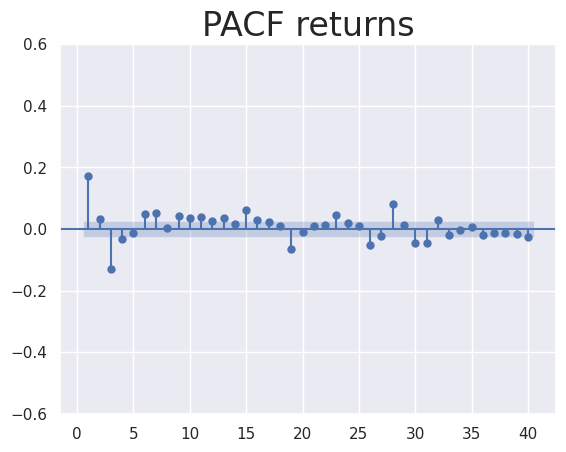

In [ ]:
sgt.plot_pacf(df_train.returns[1:], lags = 40, zero = False, method = ('ols'))   #en el día 8 se encuentra el primer valor no significativo
plt.title('PACF returns', size = 24)
plt.ylim(-0.6, 0.6)
plt.show()

##Modelo de medias móviles de orden 1

In [ ]:
model_ma_1 = ARIMA(df_train.returns[1:], order= (0,0,1))
results_ma_1 = model_ma_1.fit()
print(results_ma_1.summary())


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(0, 0, 1)   Log Likelihood                3989.755
Date:                Mon, 29 Apr 2024   AIC                          -7973.509
Time:                        03:37:21   BIC                          -7953.252
Sample:                    08-02-2002   HQIC                         -7966.493
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.360      0.000       0.016       0.024
ma.L1          0.1510      0.004     38.805      0.000       0.143       0.159
sigma2         0.0166   3.19e-05    519.138      0.0

##Modelo de medias móviles de orden 2

In [ ]:
model_ma_2 = ARIMA(df_train.returns[1:], order= (0,0,2))
results_ma_2 = model_ma_2.fit()
print(results_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_1,results_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(0, 0, 2)   Log Likelihood                4022.527
Date:                Mon, 29 Apr 2024   AIC                          -8037.053
Time:                        03:37:27   BIC                          -8010.044
Sample:                    08-02-2002   HQIC                         -8027.699
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.914      0.000       0.016       0.024
ma.L1          0.1824      0.005     40.442      0.000       0.174       0.191
ma.L2          0.1092      0.005     20.153      0.0

##Modelo de medias móviles de orden 3

In [ ]:
model_ma_3 = ARIMA(df_train.returns[1:], order= (0,0,3))
results_ma_3 = model_ma_3.fit()
print(results_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_2,results_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(0, 0, 3)   Log Likelihood                4042.623
Date:                Mon, 29 Apr 2024   AIC                          -8075.247
Time:                        03:37:34   BIC                          -8041.486
Sample:                    08-02-2002   HQIC                         -8063.554
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.266      0.000       0.016       0.024
ma.L1          0.1655      0.006     28.694      0.000       0.154       0.177
ma.L2          0.0806      0.006     12.620      0.0

##Modelo de medias móviles de orden 14

In [ ]:
model_ma_14 = ARIMA(df_train.returns[1:], order= (0,0,14))
results_ma_14 = model_ma_14.fit()
print(results_ma_14.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_3,results_ma_14, DF = 11)))   #Se obtuvo que L10 y L14 son coeficientes no significativos

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 14)   Log Likelihood                4094.256
Date:                Mon, 29 Apr 2024   AIC                          -8156.512
Time:                        03:38:22   BIC                          -8048.476
Sample:                    08-02-2002   HQIC                         -8119.094
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.231      0.000       0.015       0.025
ma.L1          0.1598      0.006     25.827      0.000       0.148       0.172
ma.L2          0.0763      0.008      9.487      0.0

##Modelo de medias móviles de orden 10

In [ ]:
model_ma_10 = ARIMA(df_train.returns[1:], order= (0,0,10))
results_ma_10 = model_ma_10.fit()
print(results_ma_10.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_3,results_ma_10, DF = 7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 10)   Log Likelihood                4085.538
Date:                Mon, 29 Apr 2024   AIC                          -8147.076
Time:                        03:38:37   BIC                          -8066.049
Sample:                    08-02-2002   HQIC                         -8119.013
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.879      0.000       0.016       0.025
ma.L1          0.1616      0.006     26.419      0.000       0.150       0.174
ma.L2          0.0792      0.008     10.029      0.0

##Modelo de medias móviles de orden 11

In [ ]:
model_ma_11 = ARIMA(df_train.returns[1:], order= (0,0,11))
results_ma_11 = model_ma_11.fit()
print(results_ma_11.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_10,results_ma_11)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 11)   Log Likelihood                4087.861
Date:                Mon, 29 Apr 2024   AIC                          -8149.722
Time:                        03:38:55   BIC                          -8061.943
Sample:                    08-02-2002   HQIC                         -8119.320
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.002      8.696      0.000       0.016       0.025
ma.L1          0.1606      0.006     25.910      0.000       0.148       0.173
ma.L2          0.0782      0.008      9.757      0.0

##Modelo de medias móviles de orden 12

In [ ]:
model_ma_12 = ARIMA(df_train.returns[1:], order= (0,0,12))
results_ma_12 = model_ma_12.fit()
print(results_ma_12.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_11,results_ma_12)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 12)   Log Likelihood                4090.332
Date:                Mon, 29 Apr 2024   AIC                          -8152.663
Time:                        03:39:24   BIC                          -8058.132
Sample:                    08-02-2002   HQIC                         -8119.923
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.002      8.509      0.000       0.016       0.025
ma.L1          0.1595      0.006     25.773      0.000       0.147       0.172
ma.L2          0.0787      0.008      9.869      0.0

##Modelo de medias móviles de orden 13

In [ ]:
model_ma_13 = ARIMA(df_train.returns[1:], order= (0,0,13))
results_ma_13 = model_ma_13.fit()
print(results_ma_13.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_12,results_ma_13)))     #Este modelo arroja un coeficiente no significativo L10, por lo que el mejor modelo sería MA (12)

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 13)   Log Likelihood                4094.181
Date:                Mon, 29 Apr 2024   AIC                          -8158.362
Time:                        03:40:02   BIC                          -8057.078
Sample:                    08-02-2002   HQIC                         -8123.282
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.295      0.000       0.015       0.025
ma.L1          0.1600      0.006     25.877      0.000       0.148       0.172
ma.L2          0.0764      0.008      9.554      0.0

#Modelo ARMA

##Modelo ARMA de orden (1,1)

In [ ]:
model_ar_1_ma_1 = ARIMA(df_train.returns[1:], order= (1,0,1))     #Este modelo  presenta un problema para converger por lo que se utilizará otro con un orden mayor
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
print(results_ar_1_ma_1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4002.274
Date:                Mon, 29 Apr 2024   AIC                          -7996.549
Time:                        03:40:12   BIC                          -7969.540
Sample:                    08-02-2002   HQIC                         -7987.194
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.708      0.000       0.016       0.025
ar.L1          0.2482      0.034      7.219      0.000       0.181       0.316
ma.L1         -0.0772      0.039     -1.972      0.0

##Modelo ARMA de orden (4,6)

In [ ]:
model_ar_4_ma_6 = ARIMA(df_train.returns[1:], order= (4,0,6))     #Este modelo arroja coeficientes no significativos y considerando que p + q = 10, se probará modelos donde p + q = 9
results_ar_4_ma_6 = model_ar_4_ma_6.fit()
print(results_ar_4_ma_6.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(4, 0, 6)   Log Likelihood                4097.565
Date:                Mon, 29 Apr 2024   AIC                          -8171.130
Time:                        03:40:47   BIC                          -8090.103
Sample:                    08-02-2002   HQIC                         -8143.067
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.003      7.244      0.000       0.015       0.025
ar.L1          1.0846      0.092     11.853      0.000       0.905       1.264
ar.L2         -0.4526      0.188     -2.413      0.0

#Modelos ARIMA

##Modelo ARIMA de orden (1,1,1)

In [ ]:
model_ar_1_i_1_ma_1 = ARIMA(df_train.Close, order= (1,1,1))     #Este modelo  presenta un problema para converger por lo que se utilizará otro con un orden mayor
results_ar_1_i_1_ma_1 = model_ar_1_i_1_ma_1.fit()
print(results_ar_1_i_1_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6326
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -32293.621
Date:                Mon, 29 Apr 2024   AIC                          64593.242
Time:                        03:40:52   BIC                          64613.499
Sample:                    08-01-2002   HQIC                         64600.258
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3250      0.012     26.036      0.000       0.301       0.350
ma.L1         -0.0486      0.015     -3.252      0.001      -0.078      -0.019
sigma2      1594.9490      1.969    809.922      0.0

##Comprobar las integraciones

In [ ]:
df_train['delta_prices'] = df_train.Close.diff(1)

<ipython-input-31-63dfe1bb233b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['delta_prices'] = df_train.Close.diff(1)


In [ ]:
sts.adfuller(df_train.delta_prices[1:])                      #Se comprueba con el test de hipótesis que los datos con una integración son estacionarios, por lo tanto no es necesario seguir integrando

(-11.300827651967179,
 1.3088147885846445e-20,
 31,
 6293,
 {'1%': -3.4313895629133992,
  '5%': -2.8619993951727514,
  '10%': -2.567014533031778},
 63398.32786974649)

##Gráfico de autocorrelación de los residuos

<ipython-input-33-6711c2457a5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]


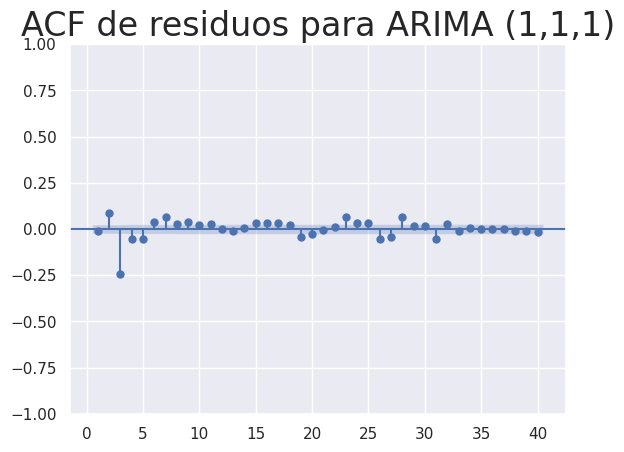

In [ ]:
df_train['res_ar_1_i_1_ma_1'] = results_ar_1_i_1_ma_1.resid.iloc[:]
sgt.plot_acf(df_train.res_ar_1_i_1_ma_1[1:], zero = False, lags = 40)       #La mayoría de los residuos tienen un valor significativo distinto de 0 por lo que deberá buscar un mejor modelo
plt.title("ACF de residuos para ARIMA (1,1,1)", size = 24)
plt.show()

In [ ]:
print("ARIMA (1,0,0): \t LL = ", results_ar_1.llf, "\t AIC = ", results_ar_1.aic) # modelo autoregresivo
print("ARIMA (0,0,1): \t LL = ", results_ma_1.llf, "\t AIC = ", results_ma_1.aic) #modelo medias móviles
print("ARIMA (1,1,1): \t LL = ", results_ar_1_i_1_ma_1.llf, "\t AIC = ", results_ar_1_i_1_ma_1.aic) #Modelo ARIMA

#De acuerdo a la información obtenida comparando los modelos más básicos de AR, MA y ARIMA, aumentar la complejidad del modelo
#no significa un mejor modelo, ya que el modelo autoregresivo poseen el valor de LL más alto y el valor AIC más bajo, por lo que nos quedaremos con estos métodos.

ARIMA (1,0,0): 	 LL =  4000.8319857616634 	 AIC =  -7995.663971523327
ARIMA (0,0,1): 	 LL =  3989.754616264334 	 AIC =  -7973.509232528668
ARIMA (1,1,1): 	 LL =  -32293.62117265076 	 AIC =  64593.24234530152


#Comparación del mejor modelo autoregresivo con el mejor modelo de medias móviles

In [ ]:
print("ARIMA  (7,0,0): \t LL = ", results_ar_7.llf,  "\t AIC = ", results_ar_7.aic) # modelo autoregresivo
print("ARIMA (0,0,12): \t LL = ", results_ma_12.llf, "\t AIC = ", results_ma_12.aic) #modelo medias móviles

#El mejor modelo al parecer es el de medias móviles que considera 12 retrasos

ARIMA  (7,0,0): 	 LL =  4077.2691749164305 	 AIC =  -8136.538349832861
ARIMA (0,0,12): 	 LL =  4090.3316474521976 	 AIC =  -8152.663294904395


#Análisis de residuos del modelo de medias móviles de orden 12

<ipython-input-54-c395d9356376>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['res_ret_ma_12'] = results_ma_12.resid.iloc[:]


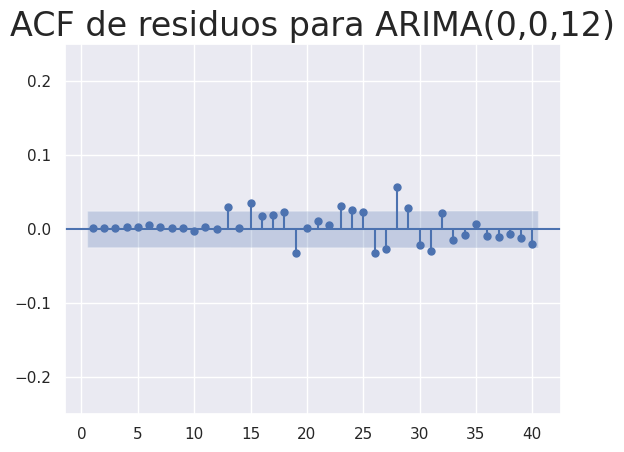

In [ ]:
df_train['res_ret_ma_12'] = results_ma_12.resid.iloc[:]
sgt.plot_acf(df_train.res_ret_ma_12[1:], zero = False, lags = 40)
plt.title("ACF de residuos para ARIMA(0,0,12)", size = 24)
plt.ylim(-0.25,0.25)
plt.show()

In [ ]:
sts.adfuller(df_train.res_ret_ma_12[1:])

(-12.36802475077789,
 5.359287816366432e-23,
 32,
 6292,
 {'1%': -3.4313897282006667,
  '5%': -2.8619994682023804,
  '10%': -2.5670145719071717},
 -8415.066676538829)